---
# Python 人工智能入门 毕业项目
# 为某平台搭建金融风控模型
## Joe(请写下你的名字)
## 2049年10月1日(请写下你完成报告的日期)
---

## 目录
<ul>
<li><a href="#definition">定义</a></li>
<li><a href="#analysis">分析</a></li>
<li><a href="#implementation">实现</a></li>
<li><a href="#result">结果</a></li>
<li><a href="#conclusion">结论</a></li>   
</ul>



---
<a id="definition"></a>
## Ⅰ.定义
我们从[kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data)获得部分信贷平台的数据，我们需要从这些数据中，挖掘出我们有用的信息，用来给借贷平台粗略的搭建一个模型，来预测在哪些情况下借贷的风险较高。

### 1.项目概况
#### 1.1 项目的背景信息
现在，借贷平台已经很常见，主要功能是给一些需要资金帮助的人群，提供金融服务，来帮助这些人群解除燃眉之急，最典型的如招行的消费贷。但是在一些情况下，会出现借贷人无法支付本金和利息，就会对金融平台产生坏账，这是需要我们解决的问题。
#### 1.2 做这个项目的出发点
上述所说的问题，我们亟待解决。如果能够成功或者部分解决这类问题。我们可以很大程度上解决金融平台的风险问题
#### 1.3 数据集的大概情况是什么
我们从下载了数据集合[lending-club-loan-data.zip](https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd101/AIPND/lending-club-loan-data.zip),其中loan.csv为主要数据集。

由于列数很多，我们无法对每个变量都进行分析，所以我们只对其中和金融相关的几个变量进行分析。

### 2.问题陈述
我们需要对数据进行处理，然后使用机器学习的方式进行数据拟合，来建议一个模型，使得在精度要求不高的情况下，有效的判断出在什么情况下的借贷风险是很高的。

### 3.评价指标
我们主要的指标是预测的准确度。次要指标是模型的复杂程度，模型的可解释性。

---
<a id="analysis"></a>
## Ⅱ.分析

### 1.数据的探索
我们需要将数据进行加工处理，主要包括以下操作：
1. 对我们感兴趣的列进行保留，不感兴趣的列进行删除
2. 对一些变量进行筛选，保留置信区间内的数据
3. 将数据分为训练集(simulate data)，优化集(optimise data)，验证集(verify data)

### 2.探索性可视化
我们对数据进行可视化处理，分析出变量的分布，以及大概对结果的影响。
下面的前3张图分别是 loan_amnt，installment，annual_inc 的分布图，从途中我们可以看到，loan_amnt 数据的波动较大，两端的数据量还是有很多的，所以相对于后两者，loan_amnt的置信区间我们取的要窄一些
下面的后3张图就是我们在过滤了置信区间之后的分布图。
数据量从原来的25万变成11万。

### 3.算法和技术
对于只是区别是否的模型，我们只需要使用逻辑回归处理即可，代码如下。

========== data columns unique info before filter
purpose ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
installment [162.87  59.83  84.33 ... 685.27 185.06 237.86]
verification_status ['Verified' 'Source Verified' 'Not Verified']
application_type ['INDIVIDUAL' 'JOINT']
home_ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
loan_amnt [ 5000.  2500.  2400. ... 32925. 32825. 32575.]
annual_inc [24000. 30000. 12252. ... 76584. 46759. 63078.]
loan_status ['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Issued']
pymnt_plan ['n' 'y']
term [' 36 months' ' 60 months']
emp_length ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7

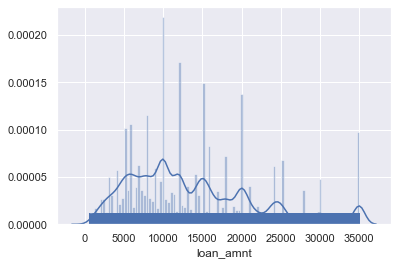

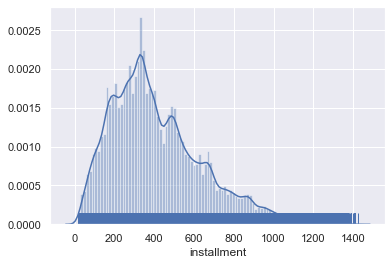

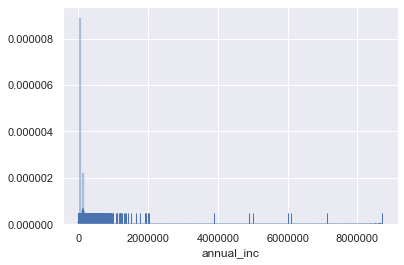

loan_amnt conf int: 8270.866924049591 19307.228687694587
installment conf int: 179.32720050133085 668.6350086561913
annual_inc conf int: 14860.63364720055 132057.76037163922
shape after calc conf int  (112547, 12)


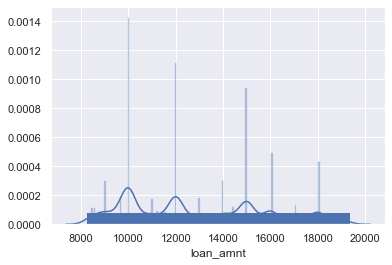

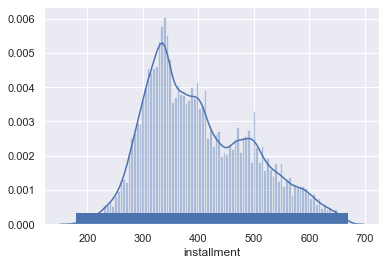

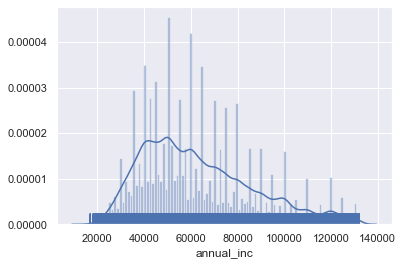

In [16]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# 源数据
path = "./loan.csv"
col_set = {'loan_amnt',
           'term',
           'installment',
           'grade',
           'emp_length',
           'home_ownership',
           'annual_inc',
           'verification_status',
           'loan_status',
           'pymnt_plan',
           'purpose',
           'application_type'}

# 我们关注的 status
status_set = ['Fully Paid',
              'Charged Off',
              'Late (16-30 days)',
              'Late (31-120 days)'
              ]

# 不含 nan 的雇佣年限
emp_length_set = ['10+ years',
                  '< 1 year',
                  '1 year',
                  '3 years',
                  '8 years',
                  '9 years',
                  '4 years', '5 years', '6 years', '2 years', '7 years']


def display_col_unique(df):
    for col in col_set:
        print(col, df[col].unique())

# 计算置信区间
def calc_col_conf_int(col, val):
    mean, sigma = np.mean(col), np.std(col)
    conf_int = stats.norm.interval(val, loc=mean, scale=sigma)
    return conf_int

# 做分布图
def distplot(df):
    sns.distplot(df["loan_amnt"], bins=100, rug=True)
    plt.show()
    sns.distplot(df["installment"], bins=100, rug=True)
    plt.show()
    sns.distplot(df["annual_inc"], bins=100, rug=True)
    plt.show()


df = pd.read_csv(path, low_memory=False, usecols=col_set)
print("========== data columns unique info before filter")
display_col_unique(df)
print("shape before ", df.shape)
# 对数据进行一次过滤
df = df[df['loan_status'].isin(status_set)]
df = df[df['emp_length'].isin(emp_length_set)]
df = df[df['annual_inc'] > 0]
print("========== data columns unique info after filter")
display_col_unique(df)
print("shape after ", df.shape)

# 做出一些数值类型的分布图
sns.set(color_codes=True)
print("before filter conf int...")
distplot(df)

loan_amnt_min, loan_amnt_max = calc_col_conf_int(df["loan_amnt"], 0.5)
print("loan_amnt conf int:", loan_amnt_min, loan_amnt_max)

installment_min, installment_max = calc_col_conf_int(df["installment"], 0.68)
print("installment conf int:", installment_min, installment_max)

annual_inc_min, annual_inc_max = calc_col_conf_int(df["annual_inc"], 0.68)
print("annual_inc conf int:", annual_inc_min, annual_inc_max)

df = df[df['loan_amnt'] > loan_amnt_min]
df = df[df['loan_amnt'] < loan_amnt_max]

df = df[df['installment'] > installment_min]
df = df[df['installment'] < installment_max]

df = df[df['annual_inc'] > annual_inc_min]
df = df[df['annual_inc'] < annual_inc_max]
print("shape after calc conf int ", df.shape)
distplot(df)
# 将结果写到文件中
df.to_csv("./loan_filter.csv")

---
<a id="implementation"></a>
## Ⅲ. 实现

### 1.数据预处理
由于得到的变量比较多，我们不可能对所有变量都一一研究，为此我们选出了我们认为很大可能相关的变量。
下面是我们选择的有关变量：

| 名称 | 解释 |
| --- | --- |
| loan_amnt| 借贷总金额，按照常理，借贷越多，风险越大|
| term | 还款时间|
| installment，annual_inc| 每月还款与年薪，如果每月还款的金额占比较大，风险较高 |
| grade | 等级相关 |
| emp_length | 工作时间长，很可能信用就高 |
| home_ownership | 租来的房子会让风险增大 |
| verification_status | 验证后的风险会有变化 |
| pymnt_plan |  毕竟有还款计划的人更可靠嘛|
| purpose | 借贷目的对风险的影响 |
| application_type | 个人贷款，和有保证人的贷款风险不一样 |

### 2.执行过程
除了将我们关心的数据提取出来，我们还要对数据进行处理，主要包括如下几个方面：
1. 数值类型不用处理
2. 分类类型添加虚拟变量
3. 我们还要将数据分为训练集，优化集合，验证集合

如下，我们将数据分为3个部分，这3个部分的数据比例是3：1：1，我们对训练集合进行数据拟合。

因为我们是逻辑归一模型，所以我们特别分出了一部分数据作为优化集合。

按照常规思路，我们会以0.5为切分点，结果大于0.5的我们认为是true,小于0.5的我们认为是false

但是我们为了优化这个参数，我们将0.3到0.7每隔0.01的正确预测数量都计算出来，从中选出预测正确数量最多的为我们的切分点。

### 3.完善

         Current function value: 0.451753
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                   risk   No. Observations:                67528
Model:                          Logit   Df Residuals:                    67487
Method:                           MLE   Df Model:                           40
Date:                Sat, 10 Aug 2019   Pseudo R-squ.:                 0.07487
Time:                        11:46:24   Log-Likelihood:                -30506.
converged:                      False   LL-Null:                       -32975.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             -2.1884        nan        nan        nan         nan         nan
loan_amnt             -0.0001   1.82e-05 

/Users/dev/proj/python/lending-club-loan/venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


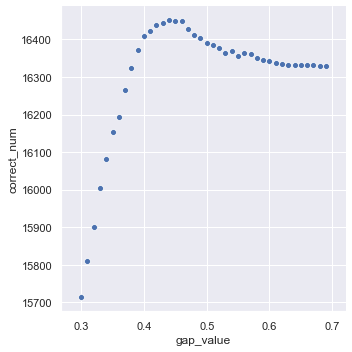

max_num_key: 0.4400000000000001
on verify_data gap = 0.5, correct_num =  16465
正确率： 0.7314721849538415
on verify_data gap =, 0.4400000000000001  correct_num =  16477
正确率： 0.7320052955654083


In [14]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


def calc_risk(data):
    status = data['loan_status']
    if status == 'Fully Paid':
        return 0
    return 1


def dumm_df(df, col_name):
    dumm = pd.get_dummies(df[col_name])
    df = pd.concat([df, dumm], axis=1)
    del df[col_name]
    return df


def dumm_df_all(df):
    df = dumm_df(df, 'term')
    df = dumm_df(df, 'grade')
    df = dumm_df(df, 'emp_length')
    df = dumm_df(df, 'home_ownership')
    df = dumm_df(df, 'verification_status')
    df = dumm_df(df, 'pymnt_plan')
    df = dumm_df(df, 'purpose')
    df = dumm_df(df, 'application_type')
    return df


def sim_cols():
    param_cols = ['intercept', 'loan_amnt', 'installment', 'annual_inc',
                  ' 36 months', ' 60 months', 'A', 'B', 'C', 'D', 'E', 'F', 'G', '1 year',
                  '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years',
                  '7 years', '8 years', '9 years', '< 1 year',
                  'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT', 'Not Verified',
                  'Source Verified', 'Verified', 'n', 'y', 'car', 'credit_card',
                  'debt_consolidation', 'educational', 'home_improvement', 'house',
                  'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
                  'small_business', 'vacation', 'wedding', 'INDIVIDUAL']
    return param_cols


# 我们之前算的过滤过的 csv
csv_path = "./loan_filter.csv"
df = pd.read_csv(csv_path)
df['risk'] = df.apply(calc_risk, axis=1)
df["intercept"] = 1
df = dumm_df_all(df)
size = (df.shape)[0]
# 需要拟合的数据
sim_data = df[0:int(size * 0.6)]
# 对正负判断优化系数的数据
opt_data = df[int(size * 0.6):int(size * 0.8)]
# 最后验证数据
verify_data = df[int(size * 0.8):]
# 拟合结果
fit_result = sm.Logit(sim_data['risk'], sim_data[sim_cols()]).fit()
print(fit_result.summary())


class DataPredict(object):

    def __init__(self, gap_value):
        self._gap_value = gap_value

    def calc_correct(self, data):
        predicted = data['predicted']
        actual = data['actual']
        if actual < 1 and predicted < self._gap_value:
            # 我们预测的值 在混淆矩阵的右下方，预测正确
            return 1
        if actual > 0 and predicted > self._gap_value:
            # 我们预测的值 在混淆矩阵的左上方，预测正确
            return 1
        return 0

    def calc_correct_num(self, data):
        predicted = fit_result.predict(data[sim_cols()])
        compare = pd.DataFrame({'predicted': predicted, 'actual': data['risk']})
        ret_data = compare.apply(self.calc_correct, axis=1)
        return sum(ret_data)


start = 0.3
end = 0.7
gap = 0.01
gap_list = []
correct_num_list = []
curr = start

correct_dic = dict()
max_num = 0
max_num_key = start
while curr < end:
    gap_list.append(curr)
    dp = DataPredict(curr)
    correct_num = dp.calc_correct_num(opt_data)
    correct_dic[curr] = correct_num
    # 找到正确率最大点
    if correct_num > max_num:
        max_num = correct_num
        max_num_key = curr

    correct_num_list.append(correct_num)
    curr = curr + gap

opt_df = pd.DataFrame({
    'gap_value': pd.Series(gap_list),
    'correct_num': pd.Series(correct_num_list)
})

sns.relplot(x="gap_value", y="correct_num", data=opt_df)
plt.show()

print("max_num_key:", max_num_key)

# 使用验证集来验证比较

# 如果使用gap = 0.5
dp = DataPredict(0.5)
correct_num = dp.calc_correct_num(verify_data)
print("on verify_data gap = 0.5, correct_num = ", correct_num)
print("正确率：", correct_num * 5 / size)

dp = DataPredict(max_num_key)
correct_num = dp.calc_correct_num(verify_data)
print("on verify_data gap =,", max_num_key, " correct_num = ", correct_num)
print("正确率：", correct_num * 5 / size)

---
<a id="result"></a>
## IV. 结果
根据上述内容，我们得出一个还算是比较复杂的模型，由于分类变量衍生出来的虚拟变量较多，我们的模型稍微有点复杂。

### 模型的评价与验证
总体而言，我们还是得到了自己想要的模型，虽然稍微复杂一些。
而且我们还使用了测试集合，优化集合，验证集合。我们通过优化集合来计算我们的切分点。
结果不是我们想象中的0.5，而是0.44，虽然最终在验证集合上证实了我们的猜想，但是我们的效果并不是很理想（正确率只上升了0.1%）

---
<a id="conclusion"></a>
## V. 项目结论

### 对项目的思考
从这个项目，我们清楚的了解了整个建模的过程。在整个过程中，我们发现在数据采样的时候遇到一些问题。
我们要尽量覆盖所有的数据，但是由于程序的限制，我们的数据并不是越多越好，如上，我们的数据导致计算的缓慢，甚至会提示达到数量的上限
由于是一个逻辑归一拟合。


### 需要作出的改进
1. 我们所选取的变量过多，导致我们的模型过于复杂，进而导致在拟合数据的时候很复杂，数据的噪音也比较多，不够准确
2. 我们需要对数据的正确性作出分析，选出真实数据的置信区间